<a href="https://colab.research.google.com/github/mddsayemm/Data-Fusion-Cooperative-Perception/blob/main/IntFus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install open3d matplotlib opencv-python imageio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [2]:
import os
import json
import math
from pathlib import Path

import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import cv2
import imageio.v2 as imageio

from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["font.size"] = 12


In [3]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [4]:
# CHANGE these paths to match your Google Drive structure
DATA_ROOT  = "/content/drive/MyDrive/Intersection"     # contains images/, point_clouds/, labels_point_clouds/
CALIB_ROOT = "/content/drive/MyDrive/Calibration" # contains s110_... calibration JSONs

IMAGES_DIR = os.path.join(DATA_ROOT, "images")
PCD_DIR    = os.path.join(DATA_ROOT, "point_clouds")
LBL_DIR    = os.path.join(DATA_ROOT, "labels_point_clouds")

print("DATA_ROOT :", DATA_ROOT)
print("CALIB_ROOT:", CALIB_ROOT)

print("\nSubfolders in images:")
print(os.listdir(IMAGES_DIR))

print("\nSubfolders in point_clouds:")
print(os.listdir(PCD_DIR))

print("\nSubfolders in labels_point_clouds:")
print(os.listdir(LBL_DIR))


DATA_ROOT : /content/drive/MyDrive/Intersection
CALIB_ROOT: /content/drive/MyDrive/Calibration

Subfolders in images:
['s110_camera_basler_south1_8mm', 's110_camera_basler_south2_8mm']

Subfolders in point_clouds:
['s110_lidar_ouster_south', 's110_lidar_ouster_north']

Subfolders in labels_point_clouds:
['s110_lidar_ouster_south', 's110_lidar_ouster_north']


In [5]:
def sorted_files_numeric(folder, valid_exts):
    """
    Return a list of filenames in 'folder' with extensions in valid_exts
    (case-insensitive), sorted by numeric value of the basename (without ext),
    e.g. 1,2,3,...84. If basename is not numeric, falls back to lexicographic.
    """
    files = []
    for fname in os.listdir(folder):
        if any(fname.lower().endswith(ext.lower()) for ext in valid_exts):
            files.append(fname)

    def sort_key(name):
        stem = os.path.splitext(name)[0]
        try:
            return int(stem)
        except ValueError:
            return stem  # fallback to string sort

    files_sorted = sorted(files, key=sort_key)
    return files_sorted


In [6]:
# LiDAR folders
LIDAR_NORTH_DIR = os.path.join(PCD_DIR, "s110_lidar_ouster_north")
LIDAR_SOUTH_DIR = os.path.join(PCD_DIR, "s110_lidar_ouster_south")

# Label folders
LBL_NORTH_DIR = os.path.join(LBL_DIR, "s110_lidar_ouster_north")
LBL_SOUTH_DIR = os.path.join(LBL_DIR, "s110_lidar_ouster_south")

# Camera folders
CAM_S1_DIR = os.path.join(IMAGES_DIR, "s110_camera_basler_south1_8mm")
CAM_S2_DIR = os.path.join(IMAGES_DIR, "s110_camera_basler_south2_8mm")

# Get numeric-sorted file lists (01..84)
lidar_n_files = sorted_files_numeric(LIDAR_NORTH_DIR, (".pcd", ".PCD"))
lidar_s_files = sorted_files_numeric(LIDAR_SOUTH_DIR, (".pcd", ".PCD"))
lbl_n_files   = sorted_files_numeric(LBL_NORTH_DIR, (".json", ".JSON"))
lbl_s_files   = sorted_files_numeric(LBL_SOUTH_DIR, (".json", ".JSON"))
cam_s1_files  = sorted_files_numeric(CAM_S1_DIR,  (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG"))
cam_s2_files  = sorted_files_numeric(CAM_S2_DIR,  (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG"))

print("LiDAR north frames:", len(lidar_n_files))
print("LiDAR south frames:", len(lidar_s_files))
print("Label north frames:", len(lbl_n_files))
print("Label south frames:", len(lbl_s_files))
print("Camera south1 frames:", len(cam_s1_files))
print("Camera south2 frames:", len(cam_s2_files))

# Make sure counts are consistent
num_frames = min(
    len(lidar_n_files),
    len(lidar_s_files),
    len(lbl_n_files),
    len(lbl_s_files),
    len(cam_s1_files),
    len(cam_s2_files),
)

print("\nUsing num_frames:", num_frames)
if num_frames == 0:
    raise RuntimeError("No frames found. Check folder names and file extensions.")


LiDAR north frames: 84
LiDAR south frames: 84
Label north frames: 84
Label south frames: 84
Camera south1 frames: 84
Camera south2 frames: 84

Using num_frames: 84


In [7]:
# Load LiDAR calibrations
with open(os.path.join(CALIB_ROOT, "s110_lidar_ouster_south.json"), "r") as f:
    calib_lidar_south = json.load(f)

with open(os.path.join(CALIB_ROOT, "s110_lidar_ouster_north.json"), "r") as f:
    calib_lidar_north = json.load(f)

# 4x4 transforms from LiDAR frames into s110_base frame
T_south_to_base = np.array(
    calib_lidar_south["transformation_matrix_s110_lidar_ouster_south_to_s110_base"],
    dtype=np.float32
)
T_north_to_base = np.array(
    calib_lidar_north["transformation_matrix_s110_lidar_ouster_north_to_s110_base"],
    dtype=np.float32
)

print("T_south_to_base shape:", T_south_to_base.shape)
print("T_north_to_base shape:", T_north_to_base.shape)

# Projection matrices from SOUTH LiDAR frame into both cameras
P_south_to_cam_s1 = np.array(
    calib_lidar_south["projection_matrix_into_s110_camera_basler_south1_8mm"],
    dtype=np.float32
)
P_south_to_cam_s2 = np.array(
    calib_lidar_south["projection_matrix_into_s110_camera_basler_south2_8mm"],
    dtype=np.float32
)

# Inverse to go base -> south-lidar
T_base_to_south = np.linalg.inv(T_south_to_base)

# Projection from BASE frame into cameras via south-lidar frame:
P_base_to_cam_s1 = P_south_to_cam_s1 @ T_base_to_south
P_base_to_cam_s2 = P_south_to_cam_s2 @ T_base_to_south

print("P_base_to_cam_s1:", P_base_to_cam_s1.shape)
print("P_base_to_cam_s2:", P_base_to_cam_s2.shape)


T_south_to_base shape: (4, 4)
T_north_to_base shape: (4, 4)
P_base_to_cam_s1: (3, 4)
P_base_to_cam_s2: (3, 4)


In [8]:
def transform_points(pts, T):
    """Apply 4x4 transform T to Nx3 points."""
    if pts.size == 0:
        return pts
    ones = np.ones((pts.shape[0], 1), dtype=np.float32)
    pts_h = np.hstack([pts.astype(np.float32), ones])
    pts_t = (T @ pts_h.T).T
    return pts_t[:, :3]

def make_bev_height_map(points,
                        x_range=(-80.0, 80.0),
                        y_range=(-80.0, 80.0),
                        resolution=0.2):
    x_min, x_max = x_range
    y_min, y_max = y_range

    x_bins = int((x_max - x_min) / resolution)
    y_bins = int((y_max - y_min) / resolution)

    bev = np.full((y_bins, x_bins), np.nan, dtype=np.float32)

    if points.size == 0:
        return bev, (x_min, x_max), (y_min, y_max)

    xs, ys, zs = points[:, 0], points[:, 1], points[:, 2]

    mask = (xs >= x_min) & (xs < x_max) & (ys >= y_min) & (ys < y_max)
    xs, ys, zs = xs[mask], ys[mask], zs[mask]

    ix = ((xs - x_min) / resolution).astype(int)
    iy = ((ys - y_min) / resolution).astype(int)

    for x_idx, y_idx, z in zip(ix, iy, zs):
        if np.isnan(bev[y_idx, x_idx]) or z > bev[y_idx, x_idx]:
            bev[y_idx, x_idx] = z

    return bev, (x_min, x_max), (y_min, y_max)

def extract_boxes_from_openlabel(label_data):
    """
    Extract 3D boxes (center, size, yaw, category) assuming
    cuboid 'val' = [x,y,z, roll, pitch, sin(yaw), cos(yaw), length, width, height]
    in BASE frame.
    """
    boxes = []
    if "openlabel" not in label_data:
        return boxes

    ol = label_data["openlabel"]
    frames = ol.get("frames", {})
    if not frames:
        return boxes

    frame_key = sorted(frames.keys())[0]
    frame_data = frames[frame_key]
    objects = frame_data.get("objects", {})

    for obj_id, obj in objects.items():
        od = obj.get("object_data", {})
        cat = od.get("type", None)
        if cat is None:
            name = od.get("name", "")
            cat = name.split("_")[0] if "_" in name else name

        cub = od.get("cuboid", None)
        if cub is None:
            continue
        if isinstance(cub, list):
            if not cub:
                continue
            cub = cub[0]

        vals = list(cub.get("val", []))
        if len(vals) < 10:
            continue

        x, y, z = vals[0], vals[1], vals[2]
        sin_yaw, cos_yaw = vals[5], vals[6]
        l, w, h = vals[7], vals[8], vals[9]
        yaw = math.atan2(sin_yaw, cos_yaw)

        boxes.append({
            "id": obj_id,
            "category": cat,
            "center": (x, y, z),
            "size": (l, w, h),
            "yaw": yaw,
        })

    return boxes

from math import cos, sin

CLASS_COLORS = {
    "CAR": (0.0, 0.7, 1.0),
    "TRUCK": (0.0, 0.8, 0.3),
    "TRAILER": (0.3, 1.0, 0.5),
    "VAN": (1.0, 0.9, 0.2),
    "BUS": (1.0, 0.6, 0.6),
    "MOTORCYCLE": (1.0, 0.4, 0.1),
    "PEDESTRIAN": (0.9, 0.4, 1.0),
    "BICYCLE": (0.4, 0.7, 1.0),
    "EMERGENCY_VEHICLE": (0.2, 0.8, 0.8),
    "OTHER": (0.8, 0.8, 0.8)
}

def get_class_color(cat):
    cat = (cat or "OTHER").upper()
    return CLASS_COLORS.get(cat, CLASS_COLORS["OTHER"])

def draw_boxes_on_bev(ax, boxes, x_range, y_range,
                      linewidth=2.0, show_labels=True):
    for box in boxes:
        (cx, cy, cz) = box["center"]
        (l, w, h) = box["size"]
        yaw = box["yaw"]
        cat = box["category"]

        dx = l / 2.0
        dy = w / 2.0
        corners = np.array([
            [ dx,  dy],
            [ dx, -dy],
            [-dx, -dy],
            [-dx,  dy],
            [ dx,  dy],
        ])

        R = np.array([
            [ cos(yaw), -sin(yaw)],
            [ sin(yaw),  cos(yaw)]
        ])

        rotated = (R @ corners.T).T
        rotated[:, 0] += cx
        rotated[:, 1] += cy

        xs = rotated[:, 0]
        ys = rotated[:, 1]
        color = get_class_color(cat)

        ax.plot(xs, ys, color=color, linewidth=linewidth)
        ax.plot(cx, cy, marker="x", color=color, markersize=4)

        if show_labels and cat is not None:
            ax.text(
                cx, cy + 0.5, cat,
                color=color,
                fontsize=8,
                ha="center", va="bottom",
                bbox=dict(facecolor="black", alpha=0.6, edgecolor="none")
            )

def project_points_to_image(points_base, P_base_to_cam, img_shape,
                            max_points=80000,
                            z_min=0.0, z_max=120.0):
    H, W = img_shape[0], img_shape[1]

    pts = points_base
    if pts.shape[0] > max_points:
        idx = np.random.choice(pts.shape[0], max_points, replace=False)
        pts = pts[idx]

    ones = np.ones((pts.shape[0], 1), dtype=np.float32)
    pts_h = np.hstack([pts.astype(np.float32), ones])
    proj = (P_base_to_cam @ pts_h.T).T

    u = proj[:, 0]
    v = proj[:, 1]
    w = proj[:, 2]

    valid = w > 1e-6
    u, v, w = u[valid], v[valid], w[valid]

    u = u / w
    v = v / w

    mask = (u >= 0) & (u < W) & (v >= 0) & (v < H)
    u, v, w = u[mask], v[mask], w[mask]

    if w.size > 0:
        d_min, d_max = w.min(), w.max()
        depth_norm = (w - d_min) / max(1e-6, (d_max - d_min))
    else:
        depth_norm = np.array([])

    return np.stack([u, v], axis=1), depth_norm

def overlay_lidar_on_image(img_rgb, uvs, depth_norm):
    overlay = img_rgb.copy()
    for (u, v), d in zip(uvs.astype(int), depth_norm):
        c = int(255 * (1.0 - d))  # nearer = brighter
        cv2.circle(overlay, (u, v), radius=1, color=(c, c, c), thickness=-1)
    return overlay


In [15]:
FRAME_IDX = 2   # <--- change this to see other frames (0..num_frames-1)
print("Using FRAME_IDX:", FRAME_IDX)

if FRAME_IDX < 0 or FRAME_IDX >= num_frames:
    raise RuntimeError(f"FRAME_IDX must be between 0 and {num_frames-1}")

# Build full file paths for this frame
lidar_n_file = os.path.join(LIDAR_NORTH_DIR, lidar_n_files[FRAME_IDX])
lidar_s_file = os.path.join(LIDAR_SOUTH_DIR, lidar_s_files[FRAME_IDX])
lbl_n_file   = os.path.join(LBL_NORTH_DIR,   lbl_n_files[FRAME_IDX])
lbl_s_file   = os.path.join(LBL_SOUTH_DIR,   lbl_s_files[FRAME_IDX])
cam_s1_file  = os.path.join(CAM_S1_DIR,      cam_s1_files[FRAME_IDX])
cam_s2_file  = os.path.join(CAM_S2_DIR,      cam_s2_files[FRAME_IDX])

print("North LiDAR :", lidar_n_file)
print("South LiDAR :", lidar_s_file)
print("North label :", lbl_n_file)
print("South label :", lbl_s_file)
print("Cam South1  :", cam_s1_file)
print("Cam South2  :", cam_s2_file)


Using FRAME_IDX: 2
North LiDAR : /content/drive/MyDrive/Intersection/point_clouds/s110_lidar_ouster_north/03.pcd
South LiDAR : /content/drive/MyDrive/Intersection/point_clouds/s110_lidar_ouster_south/03.pcd
North label : /content/drive/MyDrive/Intersection/labels_point_clouds/s110_lidar_ouster_north/03.json
South label : /content/drive/MyDrive/Intersection/labels_point_clouds/s110_lidar_ouster_south/03.json
Cam South1  : /content/drive/MyDrive/Intersection/images/s110_camera_basler_south1_8mm/03.jpg
Cam South2  : /content/drive/MyDrive/Intersection/images/s110_camera_basler_south2_8mm/03.jpg


In [16]:
# 1) Load LiDAR and transform to base frame
pcd_north = o3d.io.read_point_cloud(lidar_n_file)
pcd_south = o3d.io.read_point_cloud(lidar_s_file)

pts_north = np.asarray(pcd_north.points)
pts_south = np.asarray(pcd_south.points)
print("North points:", pts_north.shape)
print("South points:", pts_south.shape)

pts_north_base = transform_points(pts_north, T_north_to_base)
pts_south_base = transform_points(pts_south, T_south_to_base)
pts_fused_base = np.vstack([pts_north_base, pts_south_base])
print("Fused points:", pts_fused_base.shape)

# 2) BEV for fused LiDAR
bev_res = 0.2
bev_x_range = (-80.0, 80.0)
bev_y_range = (-80.0, 80.0)

bev_fused, x_range, y_range = make_bev_height_map(
    pts_fused_base,
    x_range=bev_x_range,
    y_range=bev_y_range,
    resolution=bev_res
)
print("BEV fused shape:", bev_fused.shape)

# 3) Load labels & extract boxes
with open(lbl_n_file, "r") as f:
    lbl_north = json.load(f)
with open(lbl_s_file, "r") as f:
    lbl_south = json.load(f)

boxes_n = extract_boxes_from_openlabel(lbl_north)
boxes_s = extract_boxes_from_openlabel(lbl_south)
boxes_all = boxes_n + boxes_s

print("North boxes:", len(boxes_n))
print("South boxes:", len(boxes_s))
print("Total boxes:", len(boxes_all))

# 4) Load camera images
img_s1_bgr = cv2.imread(cam_s1_file, cv2.IMREAD_COLOR)
img_s2_bgr = cv2.imread(cam_s2_file, cv2.IMREAD_COLOR)
if img_s1_bgr is None or img_s2_bgr is None:
    raise RuntimeError("Failed to load one of the camera images.")

img_s1 = cv2.cvtColor(img_s1_bgr, cv2.COLOR_BGR2RGB)
img_s2 = cv2.cvtColor(img_s2_bgr, cv2.COLOR_BGR2RGB)

print("South1 image shape:", img_s1.shape)
print("South2 image shape:", img_s2.shape)


North points: (23383, 3)
South points: (34047, 3)
Fused points: (57430, 3)
BEV fused shape: (800, 800)
North boxes: 21
South boxes: 19
Total boxes: 40
South1 image shape: (1200, 1920, 3)
South2 image shape: (1200, 1920, 3)


Projected points South1: 14415
Projected points South2: 5430


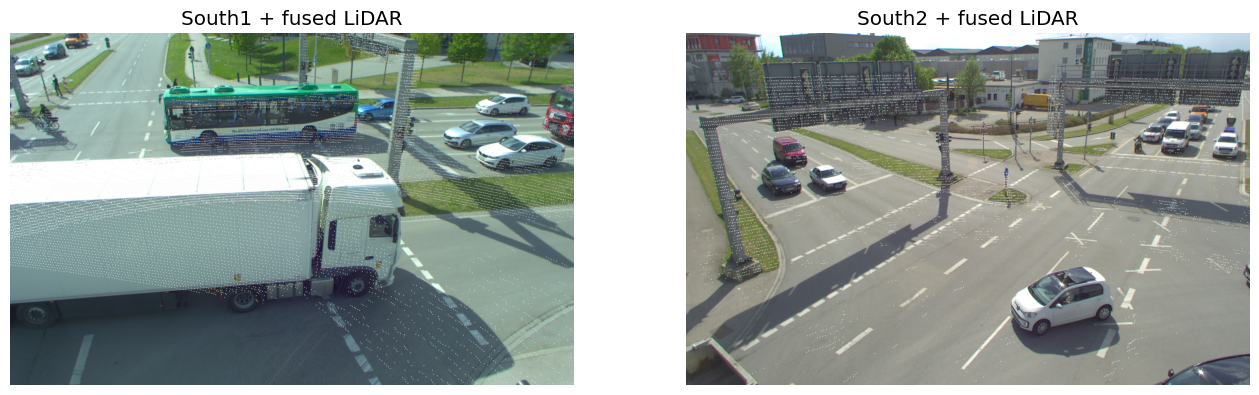

In [17]:
uv_s1, depth_s1 = project_points_to_image(
    pts_fused_base, P_base_to_cam_s1, img_s1.shape,
    max_points=100000, z_min=0.0, z_max=120.0
)
uv_s2, depth_s2 = project_points_to_image(
    pts_fused_base, P_base_to_cam_s2, img_s2.shape,
    max_points=100000, z_min=0.0, z_max=120.0
)

print("Projected points South1:", uv_s1.shape[0])
print("Projected points South2:", uv_s2.shape[0])

overlay_s1 = overlay_lidar_on_image(img_s1, uv_s1, depth_s1)
overlay_s2 = overlay_lidar_on_image(img_s2, uv_s2, depth_s2)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1); plt.imshow(overlay_s1); plt.title("South1 + fused LiDAR"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(overlay_s2); plt.title("South2 + fused LiDAR"); plt.axis("off")
plt.show()


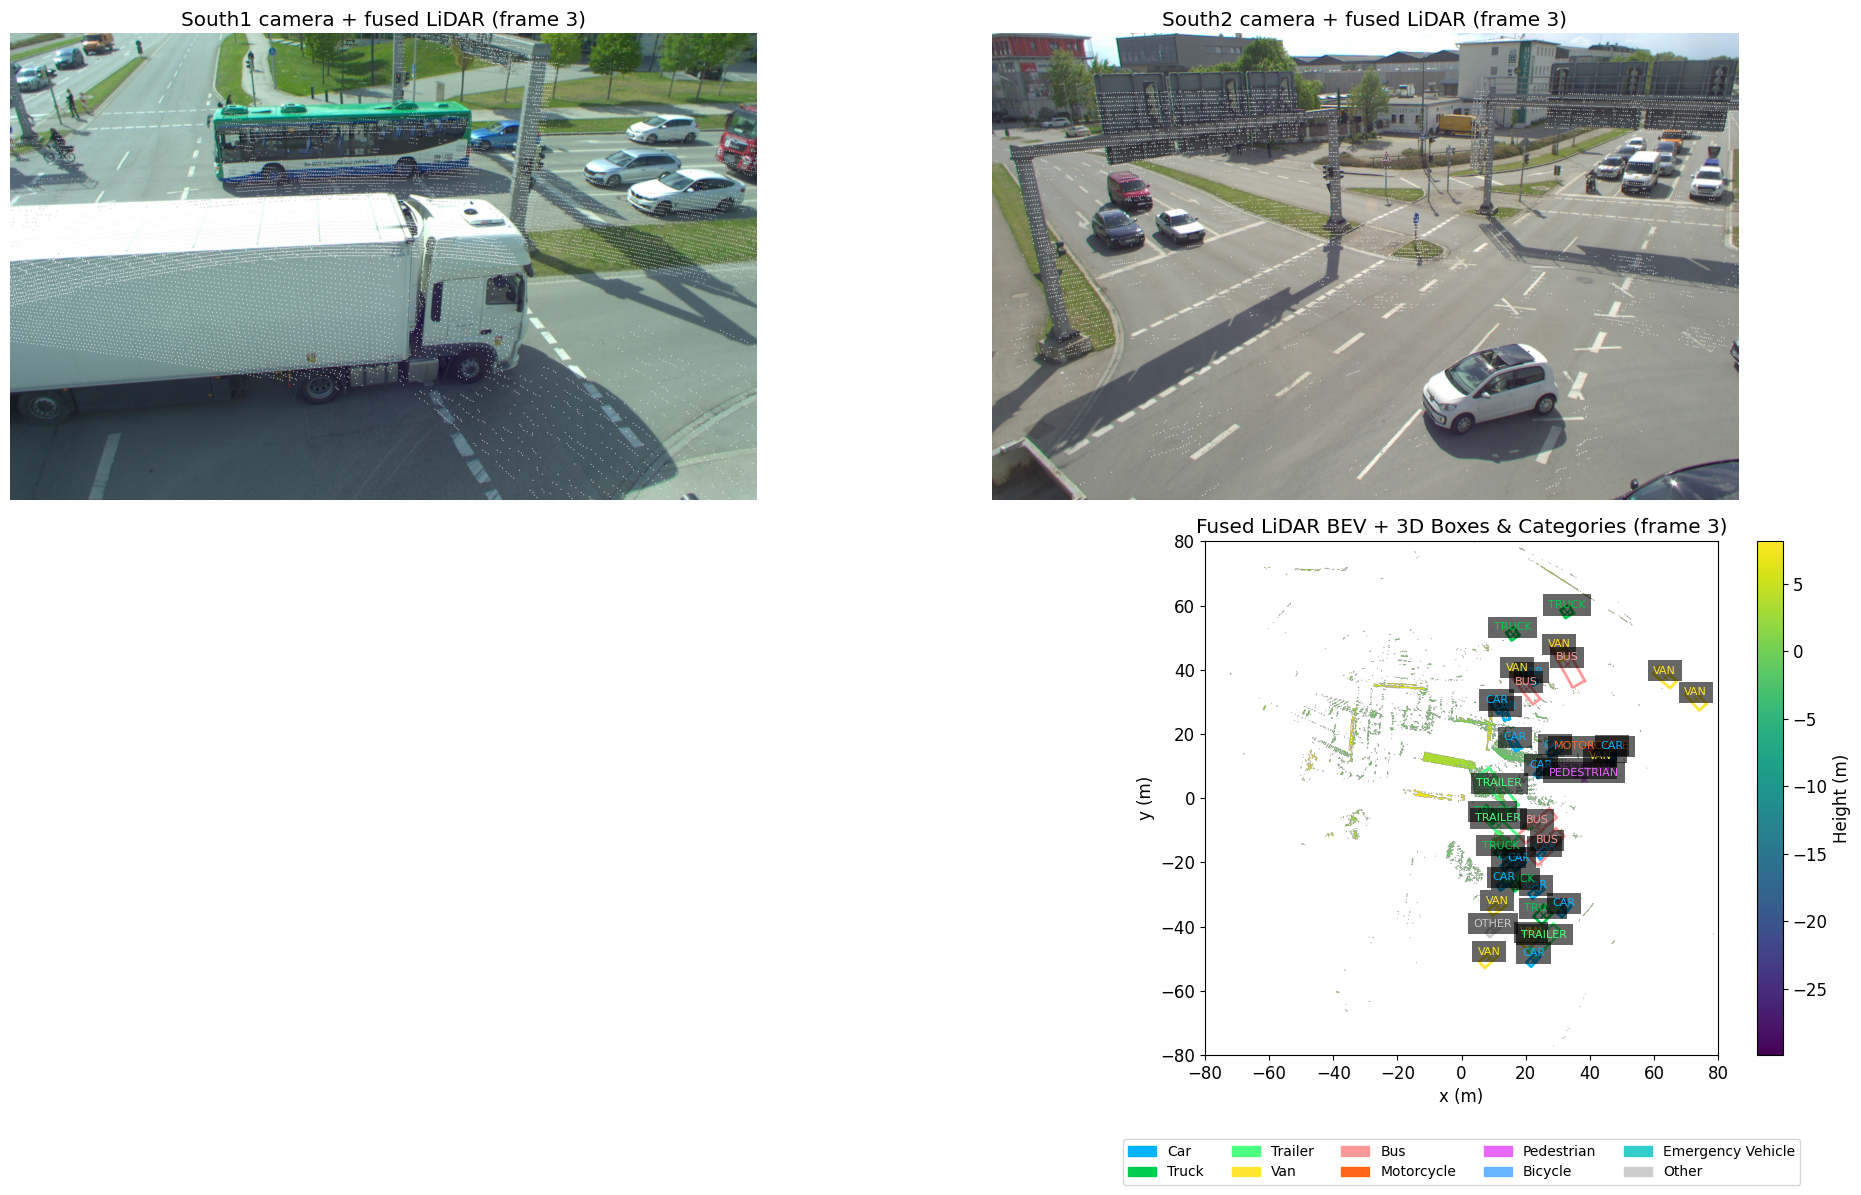

In [18]:
fig = plt.figure(figsize=(20, 12))
gs  = GridSpec(2, 2, figure=fig, height_ratios=[1, 1.1])

# Top-left: South1
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(overlay_s1)
ax1.set_title(f"South1 camera + fused LiDAR (frame {FRAME_IDX+1})")
ax1.axis("off")

# Top-right: South2
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(overlay_s2)
ax2.set_title(f"South2 camera + fused LiDAR (frame {FRAME_IDX+1})")
ax2.axis("off")

# Bottom: BEV fused + boxes
ax3 = fig.add_subplot(gs[1, :])
im = ax3.imshow(
    bev_fused,
    origin="lower",
    extent=(x_range[0], x_range[1], y_range[0], y_range[1])
)
ax3.set_xlabel("x (m)")
ax3.set_ylabel("y (m)")
ax3.set_title(f"Fused LiDAR BEV + 3D Boxes & Categories (frame {FRAME_IDX+1})")
ax3.set_aspect("equal")
ax3.grid(color="white", alpha=0.2, linestyle="--")

if boxes_all:
    draw_boxes_on_bev(ax3, boxes_all, x_range, y_range, linewidth=2.0, show_labels=True)

cbar = fig.colorbar(im, ax=ax3, fraction=0.046, pad=0.02)
cbar.set_label("Height (m)")

# Legend for classes
patches = []
for cat, color in CLASS_COLORS.items():
    patches.append(mpatches.Patch(color=color, label=cat.title().replace("_", " ")))
ax3.legend(
    handles=patches,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=5,
    fontsize=10
)

plt.tight_layout()
plt.show()


In [27]:
from matplotlib import patches as mpatches

FRAMES_DIR = "/content/frames_intersection"
os.makedirs(FRAMES_DIR, exist_ok=True)

print("Saving frames to:", FRAMES_DIR)
print("Total frames:", num_frames)

for i in range(num_frames):
    print(f"Frame {i+1}/{num_frames}")

    # Get files for this frame i
    lidar_n_file = os.path.join(LIDAR_NORTH_DIR, lidar_n_files[i])
    lidar_s_file = os.path.join(LIDAR_SOUTH_DIR, lidar_s_files[i])
    lbl_n_file   = os.path.join(LBL_NORTH_DIR,   lbl_n_files[i])
    lbl_s_file   = os.path.join(LBL_SOUTH_DIR,   lbl_s_files[i])
    cam_s1_file  = os.path.join(CAM_S1_DIR,      cam_s1_files[i])
    cam_s2_file  = os.path.join(CAM_S2_DIR,      cam_s2_files[i])

    # LiDAR -> base
    pcd_north = o3d.io.read_point_cloud(lidar_n_file)
    pcd_south = o3d.io.read_point_cloud(lidar_s_file)
    pts_north = transform_points(np.asarray(pcd_north.points), T_north_to_base)
    pts_south = transform_points(np.asarray(pcd_south.points), T_south_to_base)
    pts_fused = np.vstack([pts_north, pts_south])

    bev_fused, x_range, y_range = make_bev_height_map(
        pts_fused,
        x_range=bev_x_range,
        y_range=bev_y_range,
        resolution=bev_res
    )

    # Labels
    with open(lbl_n_file, "r") as f:
        lbl_north = json.load(f)
    with open(lbl_s_file, "r") as f:
        lbl_south = json.load(f)
    boxes_all = extract_boxes_from_openlabel(lbl_north) + extract_boxes_from_openlabel(lbl_south)

    # Images
    img_s1 = cv2.cvtColor(cv2.imread(cam_s1_file), cv2.COLOR_BGR2RGB)
    img_s2 = cv2.cvtColor(cv2.imread(cam_s2_file), cv2.COLOR_BGR2RGB)

    # Projection
    uv_s1, depth_s1 = project_points_to_image(pts_fused, P_base_to_cam_s1, img_s1.shape)
    uv_s2, depth_s2 = project_points_to_image(pts_fused, P_base_to_cam_s2, img_s2.shape)
    overlay_s1 = overlay_lidar_on_image(img_s1, uv_s1, depth_s1)
    overlay_s2 = overlay_lidar_on_image(img_s2, uv_s2, depth_s2)

    # Make figure
    fig = plt.figure(figsize=(20, 12))
    gs  = GridSpec(2, 2, figure=fig, height_ratios=[1, 1.1])

    # Top-left: South1 cam + LiDAR
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(overlay_s1)
    ax1.set_title("South1 + fused LiDAR")
    ax1.axis("off")

    # Top-right: South2 cam + LiDAR
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(overlay_s2)
    ax2.set_title("South2 + fused LiDAR")
    ax2.axis("off")

    # Bottom: fused BEV + boxes + labels
    ax3 = fig.add_subplot(gs[1, :])
    im = ax3.imshow(
        bev_fused,
        origin="lower",
        extent=(x_range[0], x_range[1], y_range[0], y_range[1])
    )
    ax3.set_xlabel("x (m)")
    ax3.set_ylabel("y (m)")
    ax3.set_title(f"Fused BEV + Boxes & Categories (frame {i+1})")
    ax3.set_aspect("equal")
    ax3.grid(color="white", alpha=0.2, linestyle="--")

    if boxes_all:
        # ✅ show_labels=True → CAR / BUS / TRUCK etc. drawn on the BEV
        draw_boxes_on_bev(ax3, boxes_all, x_range, y_range,
                          linewidth=2.0, show_labels=True)

    # -----------------------
    # Horizontal colorbar on top
    # -----------------------
    cbar_ax = fig.add_axes([0.25, 0.93, 0.50, 0.02])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("Height (m)", fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    # -----------------------
    # Legend for class colors under the BEV
    # -----------------------
    patches = []
    for cat, color in CLASS_COLORS.items():
        patches.append(mpatches.Patch(color=color, label=cat.title().replace("_", " ")))

    ax3.legend(
        handles=patches,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.18),
        ncol=5,
        fontsize=10
    )

    # Leave space at top for colorbar
    plt.tight_layout(rect=[0, 0, 1, 0.90])

    frame_path = os.path.join(FRAMES_DIR, f"frame_{i:03d}.png")
    plt.savefig(frame_path, dpi=120)
    plt.close(fig)

print("Done saving frame PNGs (with labels & legend).")


Saving frames to: /content/frames_intersection
Total frames: 84
Frame 1/84


/tmp/ipython-input-2191321598.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.90])


Frame 2/84
Frame 3/84
Frame 4/84
Frame 5/84
Frame 6/84
Frame 7/84
Frame 8/84
Frame 9/84
Frame 10/84
Frame 11/84
Frame 12/84
Frame 13/84
Frame 14/84
Frame 15/84
Frame 16/84
Frame 17/84
Frame 18/84
Frame 19/84
Frame 20/84
Frame 21/84
Frame 22/84
Frame 23/84
Frame 24/84
Frame 25/84
Frame 26/84
Frame 27/84
Frame 28/84
Frame 29/84
Frame 30/84
Frame 31/84
Frame 32/84
Frame 33/84
Frame 34/84
Frame 35/84
Frame 36/84
Frame 37/84
Frame 38/84
Frame 39/84
Frame 40/84
Frame 41/84
Frame 42/84
Frame 43/84
Frame 44/84
Frame 45/84
Frame 46/84
Frame 47/84
Frame 48/84
Frame 49/84
Frame 50/84
Frame 51/84
Frame 52/84
Frame 53/84
Frame 54/84
Frame 55/84
Frame 56/84
Frame 57/84
Frame 58/84
Frame 59/84
Frame 60/84
Frame 61/84
Frame 62/84
Frame 63/84
Frame 64/84
Frame 65/84
Frame 66/84
Frame 67/84
Frame 68/84
Frame 69/84
Frame 70/84
Frame 71/84
Frame 72/84
Frame 73/84
Frame 74/84
Frame 75/84
Frame 76/84
Frame 77/84
Frame 78/84
Frame 79/84
Frame 80/84
Frame 81/84
Frame 82/84
Frame 83/84
Frame 84/84
Done saving 

In [28]:
gif_path = "/content/intersection_fused.gif"
frame_files = sorted(
    [os.path.join(FRAMES_DIR, f)
     for f in os.listdir(FRAMES_DIR)
     if f.lower().endswith(".png")]
)

images = [imageio.imread(f) for f in frame_files]
imageio.mimsave(gif_path, images, duration=0.1)  # 0.1 s per frame

print("GIF saved at:", gif_path)


GIF saved at: /content/intersection_fused.gif


3-panel comparison for FRAME_IDX: 2 (file index, 0-based)
North LiDAR file: /content/drive/MyDrive/Intersection/point_clouds/s110_lidar_ouster_north/03.pcd
South LiDAR file: /content/drive/MyDrive/Intersection/point_clouds/s110_lidar_ouster_south/03.pcd
North label file: /content/drive/MyDrive/Intersection/labels_point_clouds/s110_lidar_ouster_north/03.json
South label file: /content/drive/MyDrive/Intersection/labels_point_clouds/s110_lidar_ouster_south/03.json
North points in base: (23383, 3)
South points in base: (34047, 3)
Fused points in base: (57430, 3)
North boxes: 21
South boxes: 19
Total boxes (fused): 40


/tmp/ipython-input-3619694728.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.90])  # leave space at top for colorbar


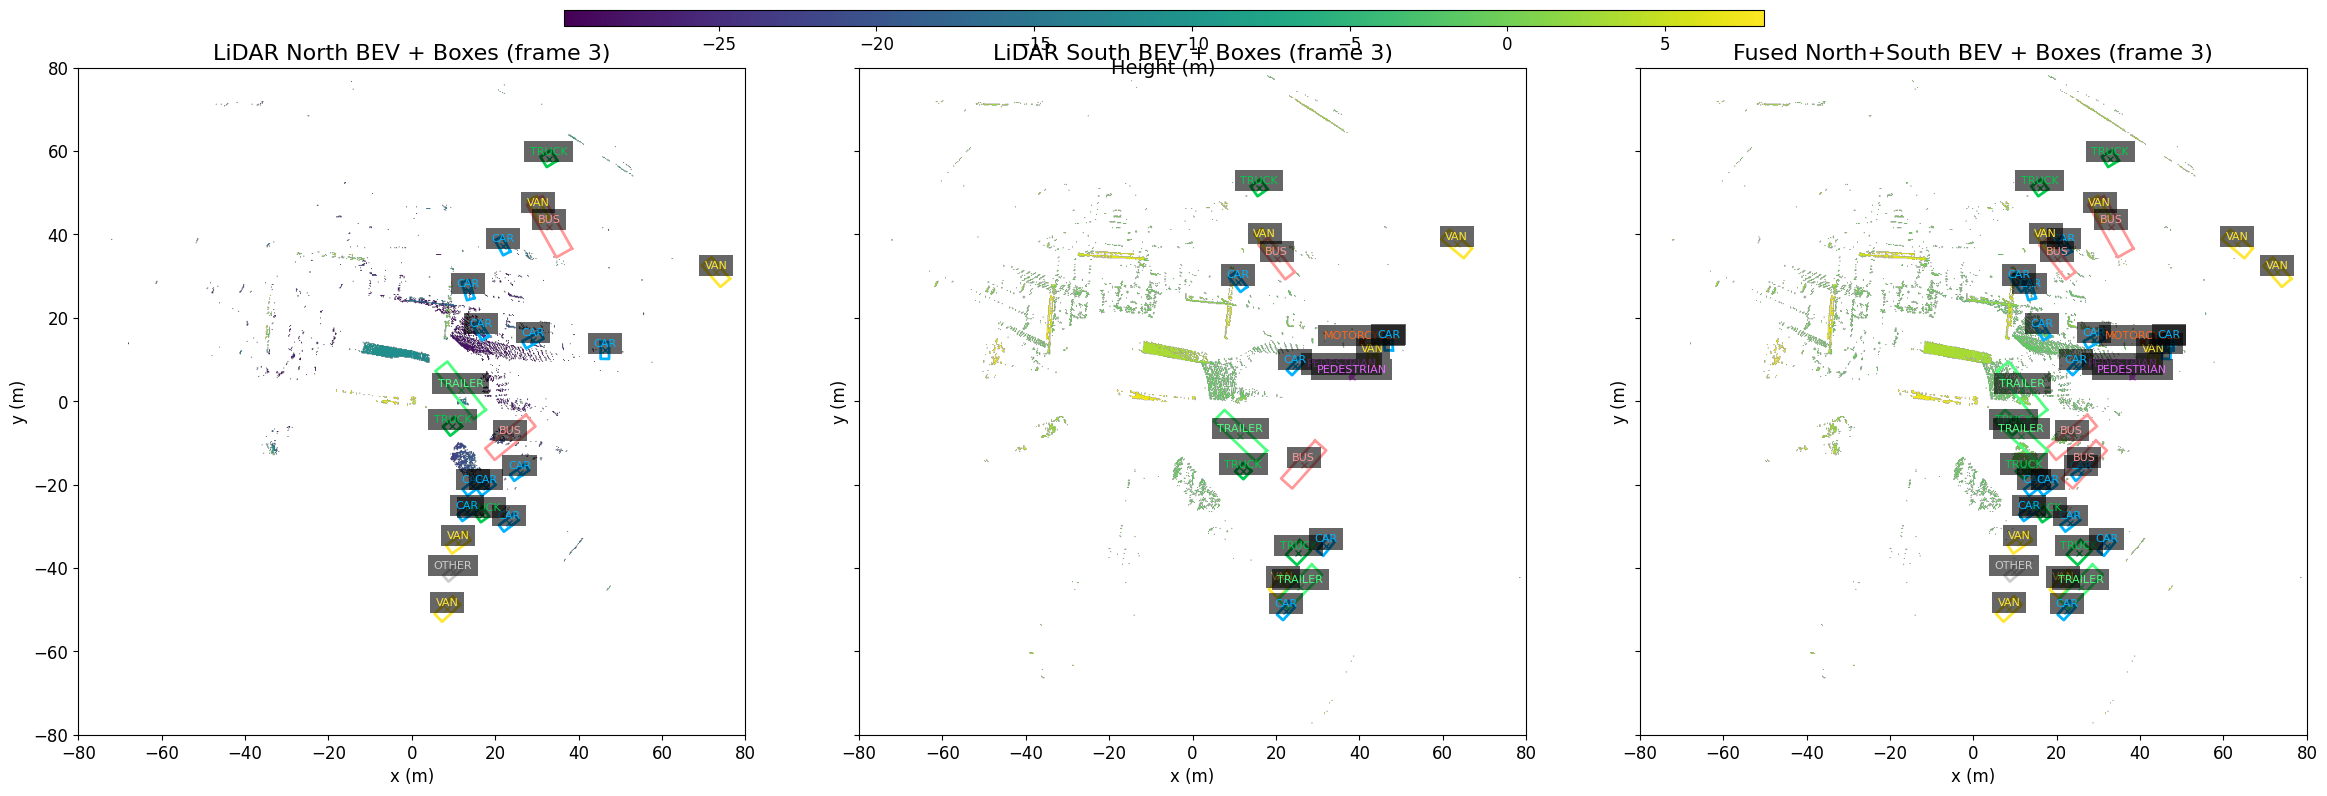

In [22]:
# ============================
# 3-panel comparison for one frame
# ============================

# You can change FRAME_IDX above, this cell just uses it.
print("3-panel comparison for FRAME_IDX:", FRAME_IDX, "(file index, 0-based)")

# 1) Load LiDAR and transform to base frame
lidar_n_file = os.path.join(LIDAR_NORTH_DIR, lidar_n_files[FRAME_IDX])
lidar_s_file = os.path.join(LIDAR_SOUTH_DIR, lidar_s_files[FRAME_IDX])
lbl_n_file   = os.path.join(LBL_NORTH_DIR,   lbl_n_files[FRAME_IDX])
lbl_s_file   = os.path.join(LBL_SOUTH_DIR,   lbl_s_files[FRAME_IDX])

print("North LiDAR file:", lidar_n_file)
print("South LiDAR file:", lidar_s_file)
print("North label file:", lbl_n_file)
print("South label file:", lbl_s_file)

pcd_north = o3d.io.read_point_cloud(lidar_n_file)
pcd_south = o3d.io.read_point_cloud(lidar_s_file)

pts_north = np.asarray(pcd_north.points)
pts_south = np.asarray(pcd_south.points)

pts_north_base = transform_points(pts_north, T_north_to_base)
pts_south_base = transform_points(pts_south, T_south_to_base)
pts_fused_base = np.vstack([pts_north_base, pts_south_base])

print("North points in base:", pts_north_base.shape)
print("South points in base:", pts_south_base.shape)
print("Fused points in base:", pts_fused_base.shape)

# 2) Make BEVs (same range & resolution for all three)
bev_res      = 0.2
bev_x_range  = (-80.0, 80.0)
bev_y_range  = (-80.0, 80.0)

bev_north, x_range, y_range = make_bev_height_map(
    pts_north_base, x_range=bev_x_range, y_range=bev_y_range, resolution=bev_res
)
bev_south, _, _ = make_bev_height_map(
    pts_south_base, x_range=bev_x_range, y_range=bev_y_range, resolution=bev_res
)
bev_fused, _, _ = make_bev_height_map(
    pts_fused_base, x_range=bev_x_range, y_range=bev_y_range, resolution=bev_res
)

# 3) Load labels & extract boxes
with open(lbl_n_file, "r") as f:
    lbl_north = json.load(f)
with open(lbl_s_file, "r") as f:
    lbl_south = json.load(f)

boxes_n = extract_boxes_from_openlabel(lbl_north)
boxes_s = extract_boxes_from_openlabel(lbl_south)
boxes_all = boxes_n + boxes_s

print("North boxes:", len(boxes_n))
print("South boxes:", len(boxes_s))
print("Total boxes (fused):", len(boxes_all))

# 4) Plot side-by-side
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)

titles = [
    f"LiDAR North BEV + Boxes (frame {FRAME_IDX+1})",
    f"LiDAR South BEV + Boxes (frame {FRAME_IDX+1})",
    f"Fused North+South BEV + Boxes (frame {FRAME_IDX+1})"
]
bevs = [bev_north, bev_south, bev_fused]
box_sets = [boxes_n, boxes_s, boxes_all]

for ax, bev, title, box_list in zip(axes, bevs, titles, box_sets):
    im = ax.imshow(
        bev,
        origin="lower",
        extent=(x_range[0], x_range[1], y_range[0], y_range[1])
    )
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("x (m)", fontsize=12)
    ax.set_ylabel("y (m)", fontsize=12)
    ax.set_aspect("equal")
    ax.grid(color="white", alpha=0.2, linestyle="--")

    if box_list:
        draw_boxes_on_bev(ax, box_list, x_range, y_range,
                          linewidth=2.0, show_labels=True)

# ============================
# HORIZONTAL COLORBAR ON TOP
# ============================

# Create a dedicated axis for the colorbar above the plots
cbar_ax = fig.add_axes([0.25, 0.93, 0.50, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Height (m)", fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Adjust layout so colorbar and subplots don't clash
plt.tight_layout(rect=[0, 0, 1, 0.90])  # leave space at top for colorbar
plt.show()


In [25]:
from matplotlib import patches as mpatches

# ==================================================
# Generate 3-panel BEV comparison frames for ALL frames (WITH LABELS)
# ==================================================

FRAMES_DIR_3WAY = "/content/frames_intersection_3way"
os.makedirs(FRAMES_DIR_3WAY, exist_ok=True)

print("Saving 3-way BEV frames to:", FRAMES_DIR_3WAY)
print("Total frames:", num_frames)

for i in range(num_frames):
    print(f"Frame {i+1}/{num_frames}")

    # 1) File paths for frame i
    lidar_n_file = os.path.join(LIDAR_NORTH_DIR, lidar_n_files[i])
    lidar_s_file = os.path.join(LIDAR_SOUTH_DIR, lidar_s_files[i])
    lbl_n_file   = os.path.join(LBL_NORTH_DIR,   lbl_n_files[i])
    lbl_s_file   = os.path.join(LBL_SOUTH_DIR,   lbl_s_files[i])

    # 2) Load & transform LiDAR into base frame
    pcd_north = o3d.io.read_point_cloud(lidar_n_file)
    pcd_south = o3d.io.read_point_cloud(lidar_s_file)

    pts_north = np.asarray(pcd_north.points)
    pts_south = np.asarray(pcd_south.points)

    pts_north_base = transform_points(pts_north, T_north_to_base)
    pts_south_base = transform_points(pts_south, T_south_to_base)
    pts_fused_base = np.vstack([pts_north_base, pts_south_base])

    # 3) BEVs
    bev_north, x_range, y_range = make_bev_height_map(
        pts_north_base, x_range=bev_x_range, y_range=bev_y_range, resolution=bev_res
    )
    bev_south, _, _ = make_bev_height_map(
        pts_south_base, x_range=bev_x_range, y_range=bev_y_range, resolution=bev_res
    )
    bev_fused, _, _ = make_bev_height_map(
        pts_fused_base, x_range=bev_x_range, y_range=bev_y_range, resolution=bev_res
    )

    # 4) Load labels & boxes
    with open(lbl_n_file, "r") as f:
        lbl_north = json.load(f)
    with open(lbl_s_file, "r") as f:
        lbl_south = json.load(f)

    boxes_n = extract_boxes_from_openlabel(lbl_north)
    boxes_s = extract_boxes_from_openlabel(lbl_south)
    boxes_all = boxes_n + boxes_s

    # 5) 3-panel figure
    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)

    titles = [
        f"LiDAR North BEV + Boxes (frame {i+1})",
        f"LiDAR South BEV + Boxes (frame {i+1})",
        f"Fused North+South BEV + Boxes (frame {i+1})"
    ]
    bevs = [bev_north, bev_south, bev_fused]
    box_sets = [boxes_n, boxes_s, boxes_all]

    for ax, bev, title, box_list in zip(axes, bevs, titles, box_sets):
        im = ax.imshow(
            bev,
            origin="lower",
            extent=(x_range[0], x_range[1], y_range[0], y_range[1])
        )
        ax.set_title(title, fontsize=14)
        ax.set_xlabel("x (m)")
        ax.set_ylabel("y (m)")
        ax.set_aspect("equal")
        ax.grid(color="white", alpha=0.2, linestyle="--")

        if box_list:
            # ✅ NOW we show labels (CAR, BUS, TRUCK, etc.)
            draw_boxes_on_bev(ax, box_list, x_range, y_range,
                              linewidth=2.0, show_labels=True)

    # ---- Horizontal colorbar at the top ----
    cbar_ax = fig.add_axes([0.25, 0.93, 0.50, 0.02])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("Height (m)", fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    # ---- Legend for class colors (under the fused panel) ----
    patches = []
    for cat, color in CLASS_COLORS.items():
        patches.append(mpatches.Patch(color=color, label=cat.title().replace("_", " ")))

    # Attach legend to the rightmost axis (fused view)
    axes[2].legend(
        handles=patches,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.18),
        ncol=5,
        fontsize=10
    )

    plt.tight_layout(rect=[0, 0, 1, 0.90])  # keep space for top colorbar
    frame_path = os.path.join(FRAMES_DIR_3WAY, f"frame_{i:03d}.png")
    plt.savefig(frame_path, dpi=120)
    plt.close(fig)

print("✅ Done saving 3-way BEV frame PNGs (with labels & legend).")


Saving 3-way BEV frames to: /content/frames_intersection_3way
Total frames: 84
Frame 1/84


/tmp/ipython-input-2614205237.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.90])  # keep space for top colorbar


Frame 2/84
Frame 3/84
Frame 4/84
Frame 5/84
Frame 6/84
Frame 7/84
Frame 8/84
Frame 9/84
Frame 10/84
Frame 11/84
Frame 12/84
Frame 13/84
Frame 14/84
Frame 15/84
Frame 16/84
Frame 17/84
Frame 18/84
Frame 19/84
Frame 20/84
Frame 21/84
Frame 22/84
Frame 23/84
Frame 24/84
Frame 25/84
Frame 26/84
Frame 27/84
Frame 28/84
Frame 29/84
Frame 30/84
Frame 31/84
Frame 32/84
Frame 33/84
Frame 34/84
Frame 35/84
Frame 36/84
Frame 37/84
Frame 38/84
Frame 39/84
Frame 40/84
Frame 41/84
Frame 42/84
Frame 43/84
Frame 44/84
Frame 45/84
Frame 46/84
Frame 47/84
Frame 48/84
Frame 49/84
Frame 50/84
Frame 51/84
Frame 52/84
Frame 53/84
Frame 54/84
Frame 55/84
Frame 56/84
Frame 57/84
Frame 58/84
Frame 59/84
Frame 60/84
Frame 61/84
Frame 62/84
Frame 63/84
Frame 64/84
Frame 65/84
Frame 66/84
Frame 67/84
Frame 68/84
Frame 69/84
Frame 70/84
Frame 71/84
Frame 72/84
Frame 73/84
Frame 74/84
Frame 75/84
Frame 76/84
Frame 77/84
Frame 78/84
Frame 79/84
Frame 80/84
Frame 81/84
Frame 82/84
Frame 83/84
Frame 84/84
✅ Done savin

In [26]:
gif_path_3way = "/content/intersection_3way_bev.gif"

frame_files_3way = sorted(
    [
        os.path.join(FRAMES_DIR_3WAY, f)
        for f in os.listdir(FRAMES_DIR_3WAY)
        if f.lower().endswith(".png")
    ]
)

print("Number of frames found for GIF:", len(frame_files_3way))

images = [imageio.imread(f) for f in frame_files_3way]
imageio.mimsave(gif_path_3way, images, duration=0.1)

print("🎉 3-way BEV GIF saved at:", gif_path_3way)


Number of frames found for GIF: 84
🎉 3-way BEV GIF saved at: /content/intersection_3way_bev.gif


In [29]:
# ==================================================
# LiDAR sensor positions in s110_base + drawing helper
# ==================================================

# Positions of LiDAR north and south in base frame (take translation from 4x4)
LIDAR_NORTH_POS_BASE = T_north_to_base[:3, 3]  # (x, y, z)
LIDAR_SOUTH_POS_BASE = T_south_to_base[:3, 3]  # (x, y, z)

print("LiDAR North position (base):", LIDAR_NORTH_POS_BASE)
print("LiDAR South position (base):", LIDAR_SOUTH_POS_BASE)

def draw_lidar_positions_on_bev(ax):
    """
    Draw markers for LiDAR north and LiDAR south in BEV.
    """
    # North LiDAR
    xn, yn, zn = LIDAR_NORTH_POS_BASE
    ax.scatter(
        xn, yn,
        marker="^",
        s=250,
        color="yellow",
        edgecolor="black",
        linewidth=2.0,
        zorder=10
    )
    ax.text(
        xn, yn + 2.0,
        "LiDAR North",
        color="yellow",
        fontsize=12,
        ha="center",
        va="bottom",
        bbox=dict(facecolor="black", alpha=0.7, edgecolor="none"),
        zorder=11
    )

    # South LiDAR
    xs, ys, zs = LIDAR_SOUTH_POS_BASE
    ax.scatter(
        xs, ys,
        marker="^",
        s=250,
        color="cyan",
        edgecolor="black",
        linewidth=2.0,
        zorder=10
    )
    ax.text(
        xs, ys + 2.0,
        "LiDAR South",
        color="cyan",
        fontsize=12,
        ha="center",
        va="bottom",
        bbox=dict(facecolor="black", alpha=0.7, edgecolor="none"),
        zorder=11
    )


LiDAR North position (base): [-2.029636   0.5641641  7.       ]
LiDAR South position (base): [-15.872579    2.300191    7.4807754]


3-panel comparison for FRAME_IDX: 2 (file index, 0-based)
North LiDAR file: /content/drive/MyDrive/Intersection/point_clouds/s110_lidar_ouster_north/03.pcd
South LiDAR file: /content/drive/MyDrive/Intersection/point_clouds/s110_lidar_ouster_south/03.pcd
North label file: /content/drive/MyDrive/Intersection/labels_point_clouds/s110_lidar_ouster_north/03.json
South label file: /content/drive/MyDrive/Intersection/labels_point_clouds/s110_lidar_ouster_south/03.json
North points in base: (23383, 3)
South points in base: (34047, 3)
Fused points in base: (57430, 3)
North boxes: 21
South boxes: 19
Total boxes (fused): 40


/tmp/ipython-input-1695475272.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.90])


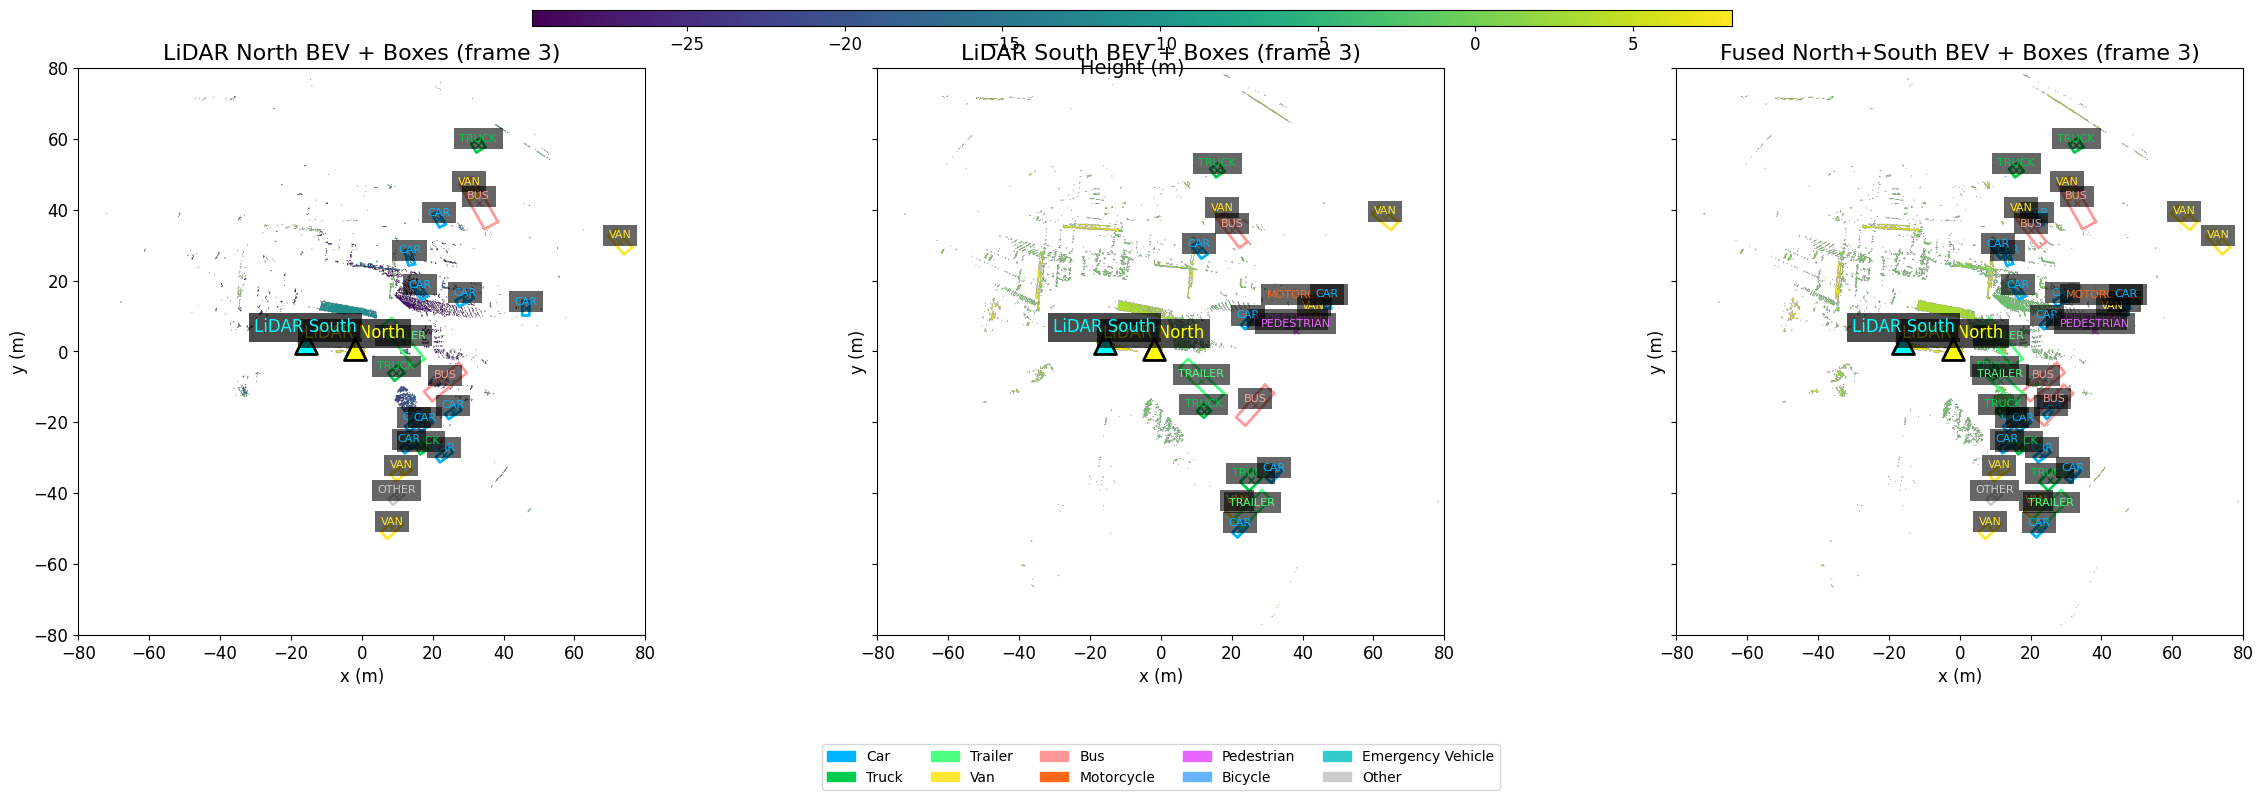

In [30]:
# ============================
# 3-panel comparison for one frame
# ============================

from matplotlib import patches as mpatches

print("3-panel comparison for FRAME_IDX:", FRAME_IDX, "(file index, 0-based)")

# 1) Load LiDAR and transform to base frame
lidar_n_file = os.path.join(LIDAR_NORTH_DIR, lidar_n_files[FRAME_IDX])
lidar_s_file = os.path.join(LIDAR_SOUTH_DIR, lidar_s_files[FRAME_IDX])
lbl_n_file   = os.path.join(LBL_NORTH_DIR,   lbl_n_files[FRAME_IDX])
lbl_s_file   = os.path.join(LBL_SOUTH_DIR,   lbl_s_files[FRAME_IDX])

print("North LiDAR file:", lidar_n_file)
print("South LiDAR file:", lidar_s_file)
print("North label file:", lbl_n_file)
print("South label file:", lbl_s_file)

pcd_north = o3d.io.read_point_cloud(lidar_n_file)
pcd_south = o3d.io.read_point_cloud(lidar_s_file)

pts_north = np.asarray(pcd_north.points)
pts_south = np.asarray(pcd_south.points)

pts_north_base = transform_points(pts_north, T_north_to_base)
pts_south_base = transform_points(pts_south, T_south_to_base)
pts_fused_base = np.vstack([pts_north_base, pts_south_base])

print("North points in base:", pts_north_base.shape)
print("South points in base:", pts_south_base.shape)
print("Fused points in base:", pts_fused_base.shape)

# 2) Make BEVs (same range & resolution for all three)
bev_res      = 0.2
bev_x_range  = (-80.0, 80.0)
bev_y_range  = (-80.0, 80.0)

bev_north, x_range, y_range = make_bev_height_map(
    pts_north_base, x_range=bev_x_range, y_range=bev_y_range, resolution=bev_res
)
bev_south, _, _ = make_bev_height_map(
    pts_south_base, x_range=bev_x_range, y_range=bev_y_range, resolution=bev_res
)
bev_fused, _, _ = make_bev_height_map(
    pts_fused_base, x_range=bev_x_range, y_range=bev_y_range, resolution=bev_res
)

# 3) Load labels & extract boxes
with open(lbl_n_file, "r") as f:
    lbl_north = json.load(f)
with open(lbl_s_file, "r") as f:
    lbl_south = json.load(f)

boxes_n = extract_boxes_from_openlabel(lbl_north)
boxes_s = extract_boxes_from_openlabel(lbl_south)
boxes_all = boxes_n + boxes_s

print("North boxes:", len(boxes_n))
print("South boxes:", len(boxes_s))
print("Total boxes (fused):", len(boxes_all))

# 4) Plot side-by-side
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)

titles = [
    f"LiDAR North BEV + Boxes (frame {FRAME_IDX+1})",
    f"LiDAR South BEV + Boxes (frame {FRAME_IDX+1})",
    f"Fused North+South BEV + Boxes (frame {FRAME_IDX+1})"
]
bevs = [bev_north, bev_south, bev_fused]
box_sets = [boxes_n, boxes_s, boxes_all]

for ax, bev, title, box_list in zip(axes, bevs, titles, box_sets):
    im = ax.imshow(
        bev,
        origin="lower",
        extent=(x_range[0], x_range[1], y_range[0], y_range[1])
    )
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("x (m)", fontsize=12)
    ax.set_ylabel("y (m)", fontsize=12)
    ax.set_aspect("equal")
    ax.grid(color="white", alpha=0.2, linestyle="--")

    if box_list:
        # show_labels=True → CAR / BUS / TRUCK etc.
        draw_boxes_on_bev(ax, box_list, x_range, y_range,
                          linewidth=2.0, show_labels=True)

    # Mark LiDAR north & south positions
    draw_lidar_positions_on_bev(ax)

# Horizontal colorbar on top
cbar_ax = fig.add_axes([0.25, 0.93, 0.50, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Height (m)", fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Legend for classes (under middle panel)
patches = []
for cat, color in CLASS_COLORS.items():
    patches.append(mpatches.Patch(color=color, label=cat.title().replace("_", " ")))

axes[1].legend(
    handles=patches,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.18),
    ncol=5,
    fontsize=10
)

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()


In [31]:
from matplotlib import patches as mpatches

# ==================================================
# Generate 3-panel BEV comparison frames for ALL frames
# ==================================================

FRAMES_DIR_3WAY = "/content/frames_intersection_3way"
os.makedirs(FRAMES_DIR_3WAY, exist_ok=True)

print("Saving 3-way BEV frames to:", FRAMES_DIR_3WAY)
print("Total frames:", num_frames)

for i in range(num_frames):
    print(f"Frame {i+1}/{num_frames}")

    # 1) File paths for frame i
    lidar_n_file = os.path.join(LIDAR_NORTH_DIR, lidar_n_files[i])
    lidar_s_file = os.path.join(LIDAR_SOUTH_DIR, lidar_s_files[i])
    lbl_n_file   = os.path.join(LBL_NORTH_DIR,   lbl_n_files[i])
    lbl_s_file   = os.path.join(LBL_SOUTH_DIR,   lbl_s_files[i])

    # 2) Load & transform LiDAR into base frame
    pcd_north = o3d.io.read_point_cloud(lidar_n_file)
    pcd_south = o3d.io.read_point_cloud(lidar_s_file)

    pts_north = np.asarray(pcd_north.points)
    pts_south = np.asarray(pcd_south.points)

    pts_north_base = transform_points(pts_north, T_north_to_base)
    pts_south_base = transform_points(pts_south, T_south_to_base)
    pts_fused_base = np.vstack([pts_north_base, pts_south_base])

    # 3) BEVs
    bev_north, x_range, y_range = make_bev_height_map(
        pts_north_base, x_range=bev_x_range, y_range=bev_y_range, resolution=bev_res
    )
    bev_south, _, _ = make_bev_height_map(
        pts_south_base, x_range=bev_x_range, y_range=bev_y_range, resolution=bev_res
    )
    bev_fused, _, _ = make_bev_height_map(
        pts_fused_base, x_range=bev_x_range, y_range=bev_y_range, resolution=bev_res
    )

    # 4) Load labels & boxes
    with open(lbl_n_file, "r") as f:
        lbl_north = json.load(f)
    with open(lbl_s_file, "r") as f:
        lbl_south = json.load(f)

    boxes_n = extract_boxes_from_openlabel(lbl_north)
    boxes_s = extract_boxes_from_openlabel(lbl_south)
    boxes_all = boxes_n + boxes_s

    # 5) 3-panel figure
    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)

    titles = [
        f"LiDAR North BEV + Boxes (frame {i+1})",
        f"LiDAR South BEV + Boxes (frame {i+1})",
        f"Fused North+South BEV + Boxes (frame {i+1})"
    ]
    bevs = [bev_north, bev_south, bev_fused]
    box_sets = [boxes_n, boxes_s, boxes_all]

    for ax, bev, title, box_list in zip(axes, bevs, titles, box_sets):
        im = ax.imshow(
            bev,
            origin="lower",
            extent=(x_range[0], x_range[1], y_range[0], y_range[1])
        )
        ax.set_title(title, fontsize=14)
        ax.set_xlabel("x (m)")
        ax.set_ylabel("y (m)")
        ax.set_aspect("equal")
        ax.grid(color="white", alpha=0.2, linestyle="--")

        if box_list:
            draw_boxes_on_bev(ax, box_list, x_range, y_range,
                              linewidth=2.0, show_labels=True)

        # LiDAR sensor positions
        draw_lidar_positions_on_bev(ax)

    # Horizontal colorbar on top
    cbar_ax = fig.add_axes([0.25, 0.93, 0.50, 0.02])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("Height (m)", fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    # Legend for class colors under center panel
    patches = []
    for cat, color in CLASS_COLORS.items():
        patches.append(mpatches.Patch(color=color, label=cat.title().replace("_", " ")))

    axes[1].legend(
        handles=patches,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.18),
        ncol=5,
        fontsize=10
    )

    plt.tight_layout(rect=[0, 0, 1, 0.90])
    frame_path = os.path.join(FRAMES_DIR_3WAY, f"frame_{i:03d}.png")
    plt.savefig(frame_path, dpi=120)
    plt.close(fig)

print("✅ Done saving 3-way BEV frame PNGs.")


Saving 3-way BEV frames to: /content/frames_intersection_3way
Total frames: 84
Frame 1/84


/tmp/ipython-input-3745937326.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.90])


Frame 2/84
Frame 3/84
Frame 4/84
Frame 5/84
Frame 6/84
Frame 7/84
Frame 8/84
Frame 9/84
Frame 10/84
Frame 11/84
Frame 12/84
Frame 13/84
Frame 14/84
Frame 15/84
Frame 16/84
Frame 17/84
Frame 18/84
Frame 19/84
Frame 20/84
Frame 21/84
Frame 22/84
Frame 23/84
Frame 24/84
Frame 25/84
Frame 26/84
Frame 27/84
Frame 28/84
Frame 29/84
Frame 30/84
Frame 31/84
Frame 32/84
Frame 33/84
Frame 34/84
Frame 35/84
Frame 36/84
Frame 37/84
Frame 38/84
Frame 39/84
Frame 40/84
Frame 41/84
Frame 42/84
Frame 43/84
Frame 44/84
Frame 45/84
Frame 46/84
Frame 47/84
Frame 48/84
Frame 49/84
Frame 50/84
Frame 51/84
Frame 52/84
Frame 53/84
Frame 54/84
Frame 55/84
Frame 56/84
Frame 57/84
Frame 58/84
Frame 59/84
Frame 60/84
Frame 61/84
Frame 62/84
Frame 63/84
Frame 64/84
Frame 65/84
Frame 66/84
Frame 67/84
Frame 68/84
Frame 69/84
Frame 70/84
Frame 71/84
Frame 72/84
Frame 73/84
Frame 74/84
Frame 75/84
Frame 76/84
Frame 77/84
Frame 78/84
Frame 79/84
Frame 80/84
Frame 81/84
Frame 82/84
Frame 83/84
Frame 84/84
✅ Done savin

In [32]:
gif_path_3way = "/content/intersection_3way_bev.gif"

frame_files_3way = sorted(
    [
        os.path.join(FRAMES_DIR_3WAY, f)
        for f in os.listdir(FRAMES_DIR_3WAY)
        if f.lower().endswith(".png")
    ]
)

print("Number of frames found for GIF:", len(frame_files_3way))

images = [imageio.imread(f) for f in frame_files_3way]
imageio.mimsave(gif_path_3way, images, duration=0.1)

print("🎉 3-way BEV GIF saved at:", gif_path_3way)


Number of frames found for GIF: 84
🎉 3-way BEV GIF saved at: /content/intersection_3way_bev.gif


In [33]:
# ==================================================
# Convert 3-way BEV PNG frames → MP4 video
# ==================================================

!apt-get install ffmpeg -y

output_mp4_path = "/content/intersection_3way_bev.mp4"

# ffmpeg will take frames in alphabetical order → frame_000.png, frame_001.png, ...
!ffmpeg -framerate 10 -i /content/frames_intersection_3way/frame_%03d.png \
        -c:v libx264 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" \
        $output_mp4_path -y

print("🎉 MP4 saved at:", output_mp4_path)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq -

In [34]:
# ==================================================
# Convert camera+BEV PNG frames → MP4 video
# ==================================================

!apt-get install ffmpeg -y

output_mp4_path2 = "/content/intersection_camera_bev.mp4"

!ffmpeg -framerate 10 -i /content/frames_intersection/frame_%03d.png \
        -c:v libx264 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" \
        $output_mp4_path2 -y

print("🎉 MP4 saved at:", output_mp4_path2)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq -